# Plotting Phase Mask and PSF
In this notebook we will load in a optimal phase mask found by the gradient descent algorithm in dLux's tutorials. We will then plot the corresponding PSF as seen by TOLIMAN.

First lets load our relevant modules.

In [63]:
import numpy as np
import dLux as dl
import matplotlib.pyplot as plt
import alphacen

# for this specific notebook set up
import os
os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

Defining a bunch of parameters.

In [80]:
# Parameters for the bandwidth
bandwidth_min = 545  # minimum wavelength in nm
bandwidth_max = 645  # maximum wavelength in nm
wavels = 1e-9 * np.linspace(bandwidth_min, bandwidth_max, 3)  # wavelengths in m

# Parameters for dLux
wavefront_npixels = 256  # wavefront layer size
detector_npixels = 128  # detector size
sampling_rate = 5  # pixels per fringe i.e. 5x Nyquist

Loading in the phase mask and converting it to an Optical Path Difference (OPD).

In [81]:
mask_dir = 'data/test_mask.npy'
mask = np.load(mask_dir)
mask_opd = dl.optics.AddOPD(dl.utils.phase_to_opd(mask, wavelength=wavels.mean()))

Creating the TOLIMAN instrument out of the optics and the binary source (Alpha Cen).

In [82]:
detector_pixel_size = dl.utils.get_pixel_scale(sampling_rate, wavels.max(), 0.125)

# Make optical system
optics = dl.utils.toliman(wavefront_npixels,
                          detector_npixels,
                          detector_pixel_size=dl.utils.radians_to_arcseconds(detector_pixel_size),
                          extra_layers=[mask_opd],
                          angular=True)

# Resetting the pixel scale of output
optics = optics.set(['AngularMFT.pixel_scale_out'], [dl.utils.arcseconds_to_radians(.375)])

# Creating a model Alpha Cen source
source = dl.BinarySource(separation=dl.utils.arcseconds_to_radians(sep),
                         wavelengths=wavels,
                         contrast=contrast,
                         flux=flux,
                         position_angle=np.deg2rad(pa),
                         )

# Creating the instrument by combining optics and source
tol = dl.Instrument(optics=optics, sources=[source])

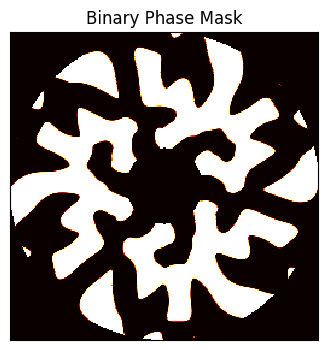

In [67]:
aperture = tol.CircularAperture.aperture

plt.figure(figsize=(10, 4))
plt.imshow(mask*aperture, cmap='hot', interpolation='nearest')
plt.xticks([]); plt.yticks([])
plt.title('Binary Phase Mask')
plt.show()

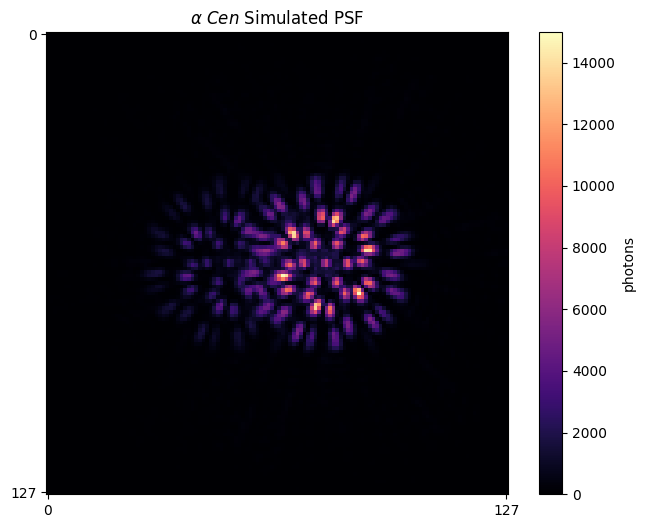

In [79]:
obj = alphacen.Psf(seed=0)
obj.flux = 6.152e7 / 10 / 2  # AVERAGE flux of the two stars per frame
mask = obj.LoadMask(mask_dir)
ideal = obj.GetPSF(mask)
PSF = obj.AddNoise(ideal)

# plotting plot
fig, (ax1)= plt.subplots(figsize=(8, 6))
c = ax1.imshow(PSF, cmap='magma')
ax1.set(title=r'$\alpha$ $Cen$ Simulated PSF',
        xticks=[0, PSF.shape[0] - 1],
        yticks=[0, PSF.shape[1] - 1],
        )
fig.colorbar(c, ax=ax1, label ='photons')
plt.show()